# Ordinary differential equations (ODEs)

- __Intro to ODEs__
- __Symbolic Solutions__
- __Direction Field Graphs__
- __Solving ODEs using Laplace Transforms__
- __Numerical Methods__
- __Numerical Integration of ODEs using SciPy__

* Differential Equations (DEs): equations where __the unknown quantity is a function__ (not a variable).
* ODEs: unknown function has only one independent variable w.r.t. to derivatives in the equation.
* Closed-form ODE solutions often don't exist. For those that do, there is a chance that we can find a solution using symbolic (using SymPy) or numerical (using the __integrate__ module from SciPy) techniques.
* Typical use case: an equation that describes the time evolution of a process, where the rate of change is a function of a property of the process.

In [1]:
import numpy as np

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True

In [3]:
import sympy
sympy.init_printing()

In [4]:
from scipy import integrate

### Symbolic ODE solving with SymPy
* generic ODE solver: __sympy.dsolve__ - attempts to auto-classify an ODE using various techniques.
* First example: Newton's law of cooling

In [5]:
t, k, T0, Ta = sympy.symbols("t, k, T_0, T_a")
T            = sympy.Function("T")

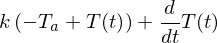

In [6]:
# apply derivative function
ode = T(t).diff(t) + k*(T(t) - Ta); ode

In [8]:
# return symbolic equality object 
# (attributes: lhs = left-hand side, rhs = right-hand side)
# includes unknown integration object C1
ode_sol = sympy.dsolve(ode); ode_sol

In [9]:
# left- and right-hand sides of the equality object
ode_sol.lhs, ode_sol.rhs

In [10]:
# define initial condition
ics = {T(0): T0}; ics

In [11]:
# substitute initial condition into solution
# returns equation for unknown integration constant C1.
C_eq = sympy.Eq(
    ode_sol.lhs.subs(t, 0).subs(ics), 
    ode_sol.rhs.subs(t, 0))
C_eq

In [12]:
# apply solver. in this case, only one answer.
C_sol = sympy.solve(C_eq); C_sol

In [13]:
# sub 1st answer into general ODE for final solution
# corresponding to given initial condition
ode_sol.subs(C_sol[0])

### Function for applying initial conditions

* define a helper function for applying initial conditions and solving for the undetermined integration

In [14]:
def apply_ics(sol, ics, x, known_params):
    """
    Apply initial conditions (ics), given as a dictionary on
    the form ics = {y(0): y0: y(x).diff(x).subs(x, 0): yp0, ...}
    to the solution of the ODE with indepdendent variable x.
    Undetermined integration constants Cn are extracted
    from the free symbols of the ODE solution, excluding symbols in
    the known_params list.
    """
    free_params = sol.free_symbols - set(known_params)
    eqs = [(sol.lhs.diff(x, n) - sol.rhs.diff(x, n)).subs(x, 0).subs(ics)
           for n in range(len(ics))]
    sol_params = sympy.solve(eqs, free_params)
    return sol.subs(sol_params)

In [15]:
ode_sol

In [16]:
apply_ics(ode_sol, ics, t, [k, Ta])

In [17]:
ode_sol = apply_ics(ode_sol, ics, t, [k, Ta]).simplify(); ode_sol

### Damped harmonic oscillator
* example of 2nd-order ODE
* x(t) = oscillator position at time=t
* omega0   = undampled frequency
* gamma    = damping ratio

In [18]:
t, omega0 = sympy.symbols("t, omega_0", positive=True)
gamma =     sympy.symbols("gamma",       complex=True)

In [19]:
x = sympy.Function("x")

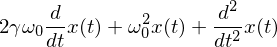

In [20]:
# construct ODE
ode = x(t).diff(t, 2) + 2 * gamma * omega0 * x(t).diff(t) + omega0**2 * x(t)
ode

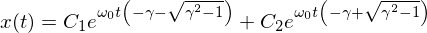

In [21]:
# construct general solution
ode_sol = sympy.dsolve(ode)
ode_sol

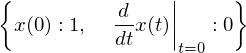

In [22]:
# define initial conditions (dict)
ics = {x(0): 1, x(t).diff(t).subs(t, 0): 0}
ics

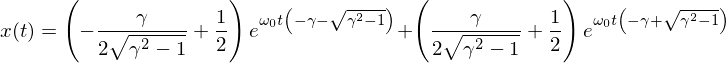

In [23]:
# apply initial conditions to general sol'n
x_t_sol = apply_ics(ode_sol, ics, t, [omega0, gamma])
x_t_sol

In [24]:
# using gamma=1 (critical damping) ==> divide by zero error
x_t_critical = sympy.limit(x_t_sol.rhs, gamma, 1)
x_t_critical

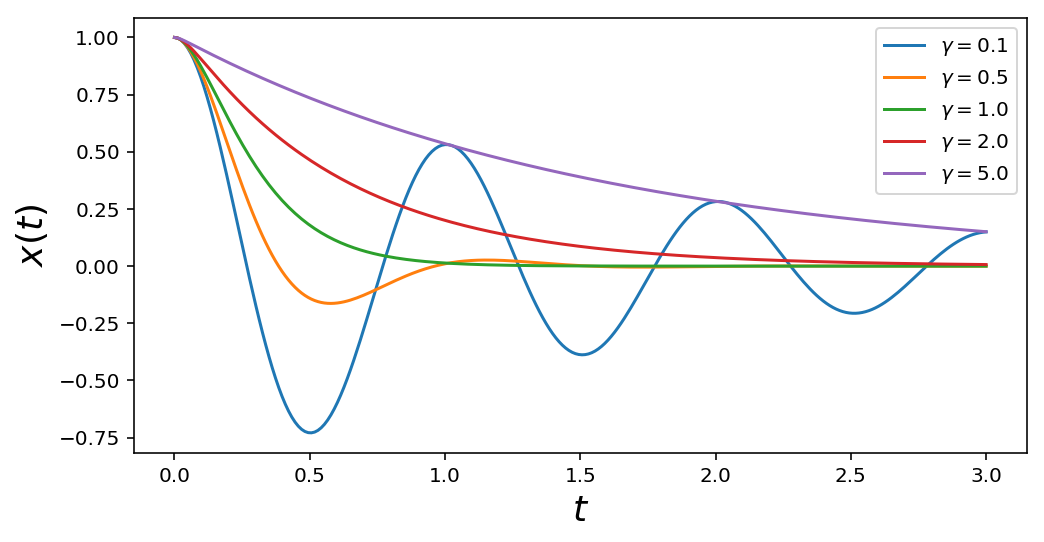

In [25]:
# plot solutions for w0 = 2pi, various values of damping ratio

fig, ax = plt.subplots(figsize=(8, 4))

tt = np.linspace(0, 3, 250)
w0 = 2*sympy.pi

for g in [0.1, 0.5, 1, 2.0, 5.0]:
    if g == 1:
        x_t = sympy.lambdify(t, 
                             x_t_critical.subs(
                                 {omega0: w0}), 'numpy')
    else:
        x_t = sympy.lambdify(t, 
                             x_t_sol.rhs.subs(
                                 {omega0: w0, gamma: g}), 'numpy')
        
    ax.plot(tt, x_t(tt).real, label=r"$\gamma = %.1f$" % g)

ax.set_xlabel(r"$t$", fontsize=18)
ax.set_ylabel(r"$x(t)$", fontsize=18)
ax.legend()


fig.savefig('ch9-harmonic-oscillator.pdf')

### Direction field graphs
* How to visualize possible solutions to arbitrary 1st order ODEs
* Built using short lines showing slope of unknown function on x-y grid

In [26]:
x = sympy.symbols("x")
y = sympy.Function("y")
f = y(x)**2 + x

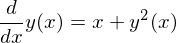

In [27]:
sympy.Eq(y(x).diff(x),f)

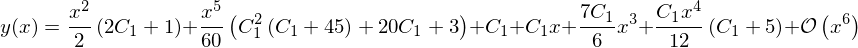

In [28]:
sympy.dsolve(y(x).diff(x)-f)

* Often SymPy cannot find a solution.

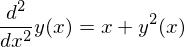

In [29]:
sympy.Eq(y(x).diff(x,x),f)

In [30]:
sympy.dsolve(y(x).diff(x,x)-f)

NotImplementedError: solve: Cannot solve -x - y(x)**2 + Derivative(y(x), x, x)

### Direction field graphs
* Useful technique for visualizing possible solutions to 1st-order ODEs.
* Shown as short lines that show slope of unknown function in X-Y plane.

In [31]:
def plot_direction_field(x, y_x, f_xy, x_lim=(-5, 5), y_lim=(-5, 5), ax=None):
    
    f_np = sympy.lambdify((x, y_x), f_xy, 'numpy')
    
    x_vec = np.linspace(x_lim[0], x_lim[1], 20)
    y_vec = np.linspace(y_lim[0], y_lim[1], 20)
    
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 4))

    dx = x_vec[1] - x_vec[0]
    dy = y_vec[1] - y_vec[0]

    for m, xx in enumerate(x_vec):
        for n, yy in enumerate(y_vec):
            Dy = f_np(xx, yy) * dx
            Dx = 0.8 * dx**2 / np.sqrt(dx**2 + Dy**2)
            Dy = 0.8 * Dy*dy / np.sqrt(dx**2 + Dy**2)
            ax.plot([xx - Dx/2, xx + Dx/2],
                    [yy - Dy/2, yy + Dy/2], 'b', lw=0.5)
    ax.axis('tight')

    ax.set_title(r"$%s$" %
                 (sympy.latex(sympy.Eq(y(x).diff(x), f_xy))),
                 fontsize=18)
    
    return ax

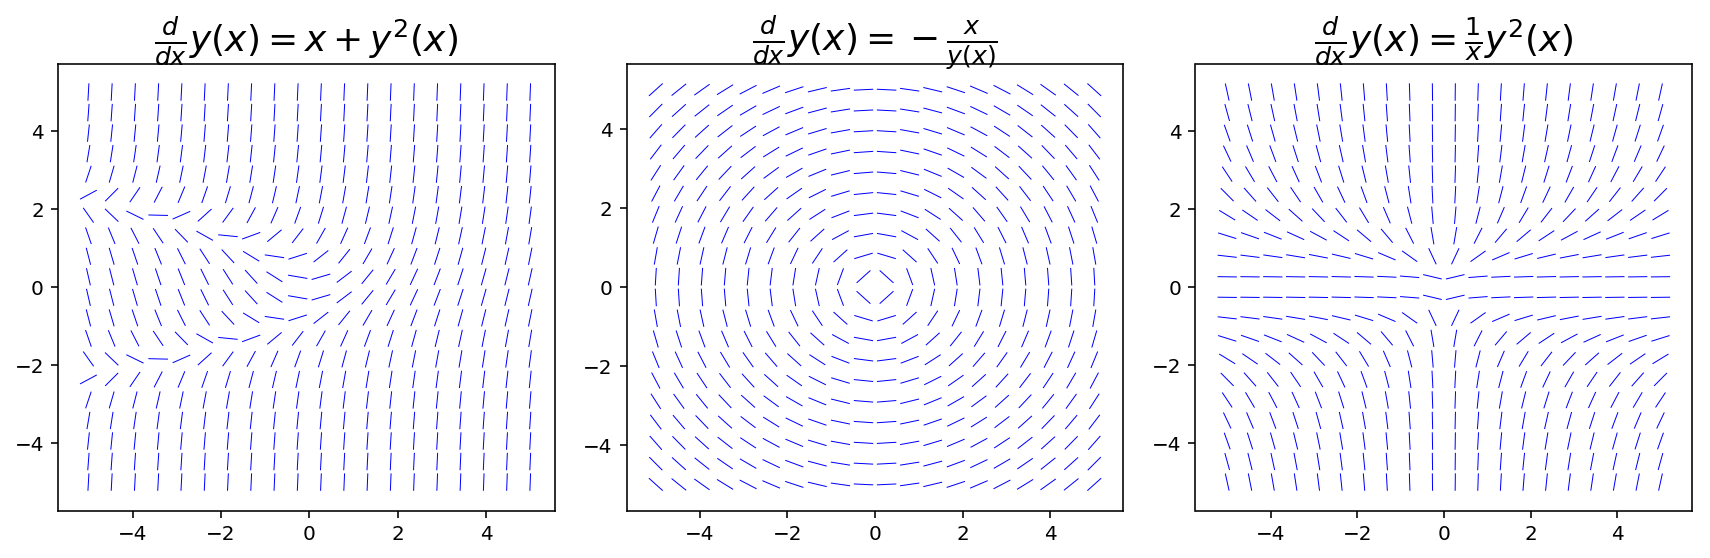

In [32]:
# Example DFs for three 1st-order ODEs
x, y = sympy.symbols("x"), sympy.Function("y")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plot_direction_field(x, y(x),      y(x)**2 + x, ax=axes[0])
plot_direction_field(x, y(x), -x / y(x),        ax=axes[1])
plot_direction_field(x, y(x),      y(x)**2 / x, ax=axes[2])

fig.tight_layout()
fig.savefig('ch9-direction-field.pdf')

### Inexact solutions to ODEs

In [33]:
x = sympy.symbols("x")
y = sympy.Function("y")

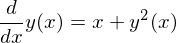

In [34]:
# define the ODE
f = y(x)**2 + x
sympy.Eq(y(x).diff(x), f)

In [35]:
# define initial condition y(0)=0
ics = {y(0): 0}

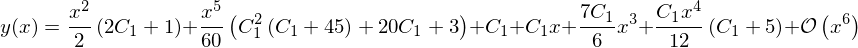

In [36]:
# define general solution
ode_sol = sympy.dsolve(y(x).diff(x) - f); ode_sol

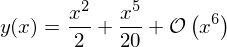

In [37]:
# alternative method, using apply_ics
ode_sol = apply_ics(ode_sol, {y(0): 0}, x, []); ode_sol

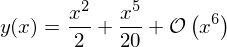

In [38]:
# another alternative, directly specifies init condition using ics keyword
ode_sol = sympy.dsolve(y(x).diff(x) - f, ics=ics); ode_sol

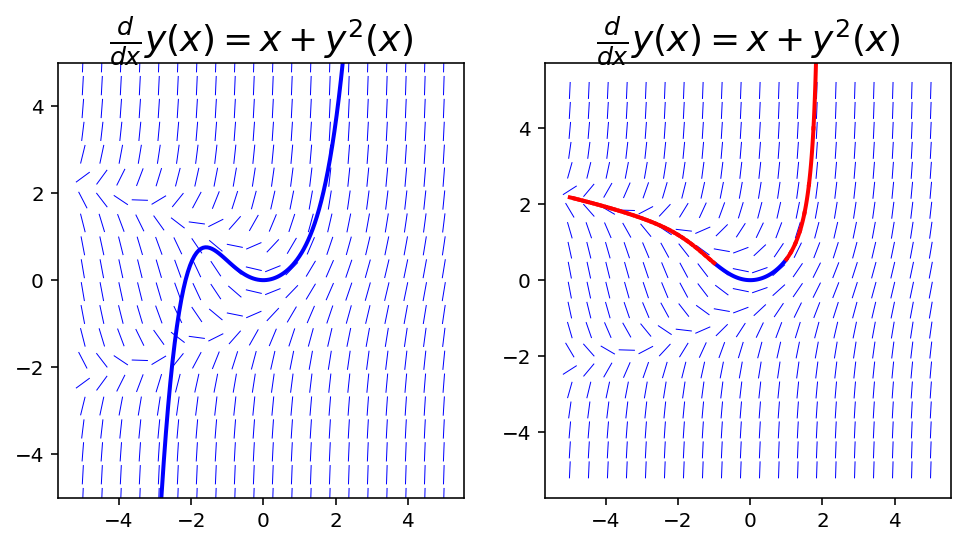

In [39]:
# plot approximate solution & direction field
# solution with extended validity range also found by iterative ODE solving across x.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_direction_field(x, y(x), f, ax=axes[0])
x_vec = np.linspace(-3, 3, 100)
axes[0].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)
axes[0].set_ylim(-5, 5)

plot_direction_field(x, y(x), f, ax=axes[1])
x_vec = np.linspace(-1, 1, 100)
axes[1].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)

ode_sol_m = ode_sol_p = ode_sol
dx = 0.125
for x0 in np.arange(1, 2., dx):
    x_vec = np.linspace(x0, x0 + dx, 100)
    ics = {y(x0): ode_sol_p.rhs.removeO().subs(x, x0)}
    ode_sol_p = sympy.dsolve(y(x).diff(x) - f, ics=ics, n=6)
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_p.rhs.removeO())(x_vec), 'r', lw=2)

for x0 in np.arange(1, 5, dx):
    x_vec = np.linspace(-x0-dx, -x0, 100)
    ics = {y(-x0): ode_sol_m.rhs.removeO().subs(x, -x0)}
    ode_sol_m = sympy.dsolve(y(x).diff(x) - f, ics=ics, n=6)
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_m.rhs.removeO())(x_vec), 'r', lw=2)
    
#fig.tight_layout()
#fig.savefig("ch9-direction-field-and-approx-sol.pdf")

* Above: direction field graph of ODE dy(x)/dx = yx^2+x
* Above, left panel:
    - 5th-order power-series solution around x=0
    - approximate solutin aligns well with direction field near x=0
    - starts to deviate for |x|>1
    - suggests approximate solution no longer valid.
* Above, right panel:
    - consecutive power-series expansions for -5<x<2, with 0.125 spacing
    - aligns better with direction field throughout shown range

### Laplace transformation method
* alternative to SymPy 'black-box" __dsolve()__ method
* technique: laplace-transform the ODE into an algebraic equation (can be easier to solve) - then use inverse-laplace-transform to to obtain solution to original problem.

In [40]:
t    = sympy.symbols("t", positive=True)
s, Y = sympy.symbols("s, Y", real=True)
y    = sympy.Function("y")

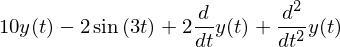

In [41]:
# find ODE for driven harmonic oscillator
ode = y(t).diff(t, 2) + 2 * y(t).diff(t) + 10 * y(t) - 2 * sympy.sin(3*t)
ode

In [42]:
# do transform of unknown qty y(t)
L_y = sympy.laplace_transform(y(t), t, s); L_y

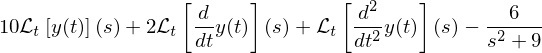

In [43]:
# do transform of entire ODE
L_ode = sympy.laplace_transform(ode, t, s, noconds=True); L_ode

In [44]:
# Evaluate the unevaluted laplace transforms of derivatives of functions

def laplace_transform_derivatives(e):
    if isinstance(e, sympy.LaplaceTransform):
        if isinstance(e.args[0], sympy.Derivative):
            d, t, s = e.args
            n = len(d.args) - 1
            return ((s**n) * sympy.LaplaceTransform(d.args[0], t, s) - 
                    sum([s**(n-i) * sympy.diff(d.args[0], t, i-1).subs(t, 0)
                         for i in range(1, n+1)]))
        
    if isinstance(e, (sympy.Add, sympy.Mul)):
        t = type(e)
        return t(*[laplace_transform_derivatives(arg) for arg in e.args])
    
    return e

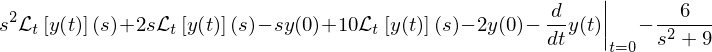

In [45]:
# apply function to laplace-transformed ODE equation
L_ode_2 = laplace_transform_derivatives(L_ode); L_ode_2

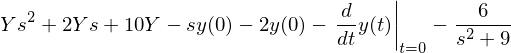

In [46]:
# simplified notation
L_ode_3 = L_ode_2.subs(L_y, Y); L_ode_3

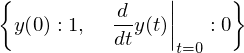

In [47]:
# specify boundary conditions
ics = {y(0): 1, y(t).diff(t).subs(t, 0): 0}; ics

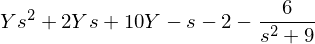

In [48]:
# sub them back into laplace-transformed ODE
L_ode_4 = L_ode_3.subs(ics); L_ode_4

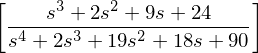

In [49]:
# now, can be solved for Y:
Y_sol = sympy.solve(L_ode_4, Y); Y_sol

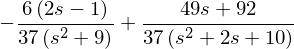

In [50]:
# list of above solutions contains only one element.
sympy.apart(Y_sol[0])

In [51]:
# get solution to original problem in time domain
y_sol = sympy.inverse_laplace_transform(Y_sol[0], s, t)

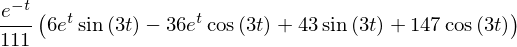

In [52]:
sympy.simplify(y_sol)

In [53]:
y_t = sympy.lambdify(t, y_sol, 'numpy')

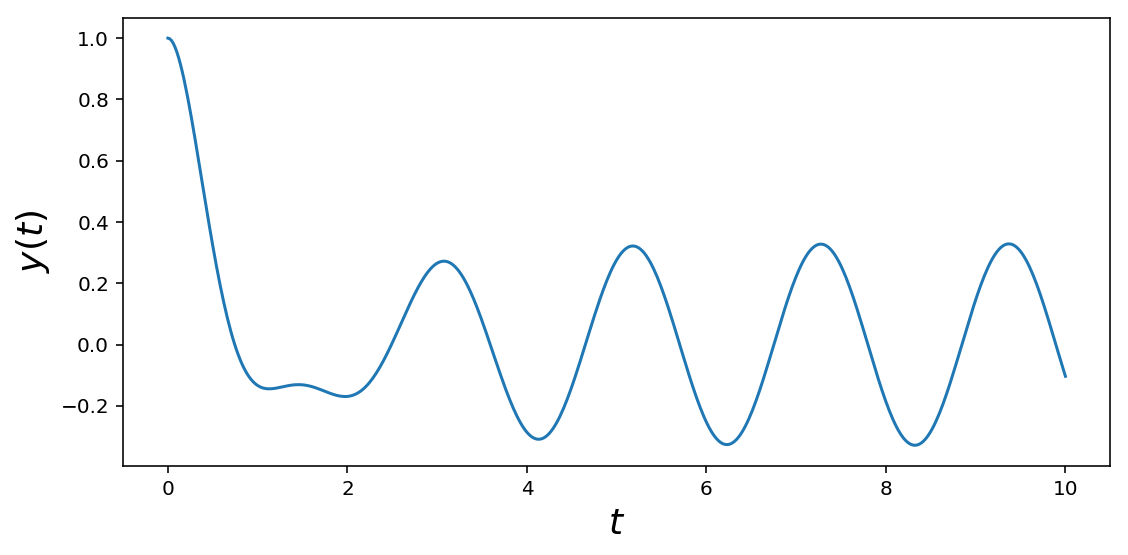

In [54]:
# let's see what we've got:
fig, ax = plt.subplots(figsize=(8, 4))

tt = np.linspace(0, 10, 500)
ax.plot(tt, y_t(tt).real)
ax.set_xlabel(r"$t$", fontsize=18)
ax.set_ylabel(r"$y(t)$", fontsize=18)
fig.tight_layout()

### Numerical integration of ODEs using SciPy
* Most ODEs can't be solved analytically - use numerical approaches instead
* Multiple approaches - most based on __Euler's method__
* Many implementations available - already pkgd into SciPy

* Two ODE solver interfaces: __integrate.odeint()__ is simplier; __integrate.ode()__ is more flexible.

In [55]:
# example using odeint()

x = sympy.symbols("x")
y = sympy.Function("y")
f = y(x)**2 + x
f_np = sympy.lambdify((y(x), x), f, 'math')
y0 = 0

In [56]:
# odeint() args:
# right-hand-evaluator-function
# unknown-func-init-conditions
# independent-var-values)

xp = np.linspace(0, 1.9, 100)
yp = integrate.odeint(f_np, y0, xp)
xp.shape, yp.shape

In [57]:
xm = np.linspace(0, -5, 100)
ym = integrate.odeint(f_np, y0, xm)
xm.shape, ym.shape

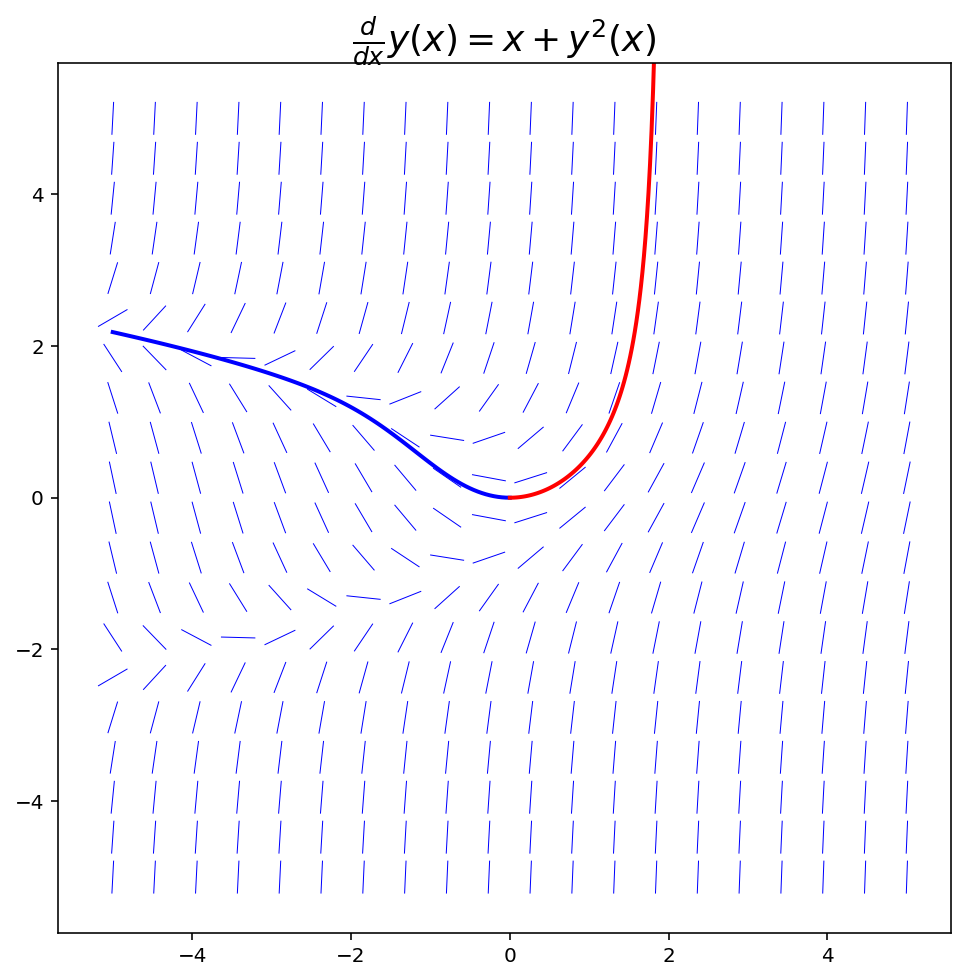

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot_direction_field(x, y(x), f, ax=ax)
ax.plot(xm, ym, 'b', lw=2)
ax.plot(xp, yp, 'r', lw=2)
fig.savefig('ch9-odeint-single-eq-example.pdf')

# below: direction field graph indicates
# the solution aligns well at every point in the graph (as expected).

### Vector-valued ODE problems
* Example: Lotka-Volterra equations describe dynamics of coupled ODEs, aka predator-prey systems.

$$
x'(t) = a x - b x y
$$

$$
y'(t) = c x y - d y
$$

In [61]:
a = 0.4   # a = prey birthrate
b = 0.002 # b = predator>prey consumption rate
c = 0.001 # c = predator>prey growth/consumption rate
d = 0.7   # d = predator death rate

In [62]:
# need func for right-hand side of ODE, in vector form:
def f(xy, t):
    x, y = xy
    return [a * x - b * x * y,
            c * x * y - d * y]

In [63]:
# initial conditions: 600 prey animals, 400 predator animals
xy0 = [600, 400]

In [64]:
t = np.linspace(0, 50, 250)

In [66]:
# odeint() integrates the ODE problem & returns array of
# x(t), y(t) for each of 250 values in t.
xy_t = integrate.odeint(f, xy0, t)
xy_t.shape

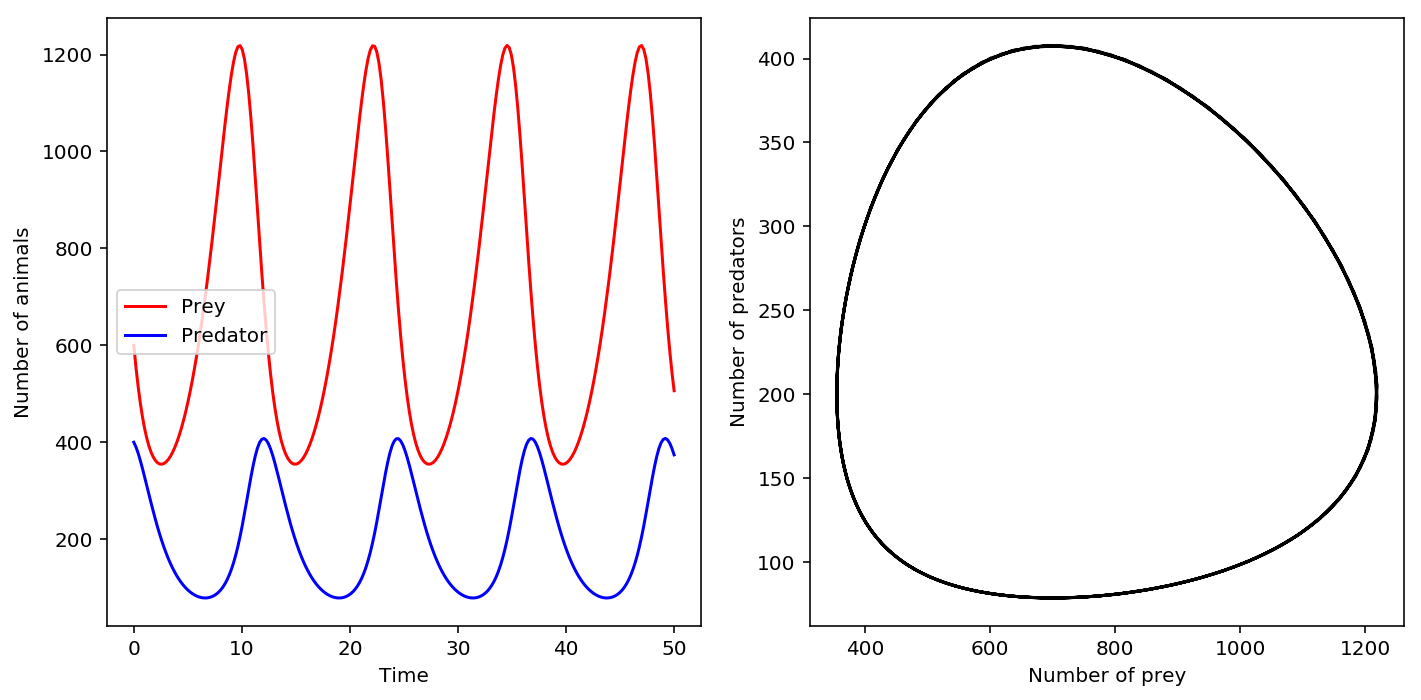

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].plot(t, xy_t[:,0], 'r', label="Prey")
axes[0].plot(t, xy_t[:,1], 'b', label="Predator")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Number of animals")
axes[0].legend()

axes[1].plot(xy_t[:,0], xy_t[:,1], 'k')
axes[1].set_xlabel("Number of prey")
axes[1].set_ylabel("Number of predators")
fig.tight_layout()
fig.savefig('ch9-lokta-volterra.pdf')

### Lorenz equations
* three coupled nonlinear ODEs
* known for chaotic solutions, sensitive to sigma, rho, beta

$$
x'(t) = \sigma(y - x)
$$
$$
y'(t) = x(\rho - z) - y 
$$
$$
z'(t) = x y - \beta z
$$

In [68]:
def f(xyz, t, rho, sigma, beta):
    x, y, z = xyz
    return [sigma * (y - x),
            x * (rho - z) - y,
            x * y - beta * z]

In [69]:
rho, sigma, beta = 28, 8, 8/3.0

In [70]:
t = np.linspace(0, 25, 10000)

In [71]:
xyz0 = [1.0, 1.0, 1.0]

In [72]:
xyz1 = integrate.odeint(f, xyz0, t, args=(rho,   sigma,     beta))
xyz2 = integrate.odeint(f, xyz0, t, args=(rho,   sigma, 0.6*beta))
xyz3 = integrate.odeint(f, xyz0, t, args=(rho, 2*sigma, 0.6*beta))
xyz3.shape

In [73]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

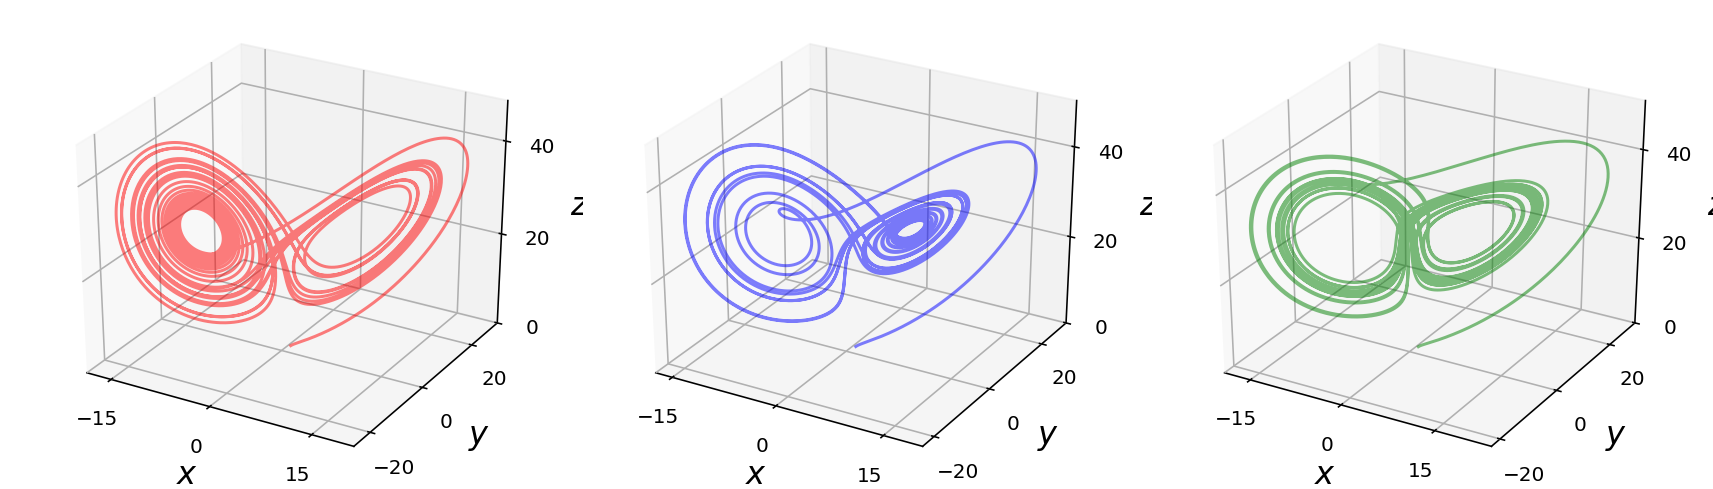

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5), subplot_kw={'projection': '3d'})

for ax, xyz, c in [(ax1, xyz1, 'r'), (ax2, xyz2, 'b'), (ax3, xyz3, 'g')]:
    ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], c, alpha=0.5)
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$y$', fontsize=16)
    ax.set_zlabel('$z$', fontsize=16)
    ax.set_xticks([-15, 0, 15])
    ax.set_yticks([-20, 0, 20])
    ax.set_zticks([0, 20, 40])

fig.tight_layout()
fig.savefig('ch9-lorenz-equations.pdf')

# below: ODE solution plots for 3 sets of parameters, but with same initial conditions.

### Alternative to odeint(): object-oriented integrate.ode
* Use case: Coupled damped springs
* 2nd-order, nonlinear ODEs -- for a double pendulum
* equations of motion are for angular deflection of 1st & 2nd pendulums
* 1st pendulum = attached to fixed support
* 2nd pendulum = attached to 1st pendulum
* [scienceworld.com](http://scienceworld.wolfram.com/physics/DoublePendulum.html)

Describing the dynamics of two coupled springs as second-order equations:

\begin{eqnarray}
m_1 x_1''(t) + \gamma_1 x_1'(t) + k_1 (x_1(t) - l_1) - k_2 (x_2(t) - x_1(t) - l_2) &=& 0\\
m_2 x_2''(t) + \gamma_2 x_2' + k_2 (x_2 - x_1 - l_2) &=& 0
\end{eqnarray}

To solve using SciPy, write it in standard form with 4 coupled first-order equations.

\begin{align}
y_1'(t) &= y_2(t) \\
y_2'(t) &= -\gamma_1/m_1 y_2(t) - k_1/m_1 (y_1(t) - l_1) + k_2 (y_3(t) - y_1(t) - l_2)/m_1 \\
y_3'(t) &= y_4(t) \\
y_4'(t) &= - \gamma_2 y_4(t)/m_2 - k_2 (y_3(t) - y_1(t) - l_2)/m_2 \\
\end{align}

In [75]:
# define function f(t,y(t))
# bunch parameters into a tuple (unpacked in 1st line of function def)
def f(t, y, args):
    m1, k1, g1, m2, k2, g2 = args
    
    return [y[1], 
            - k1/m1 * y[0] + k2/m1 * (y[2] - y[0]) - g1/m1 * y[1], 
            y[3], 
            - k2/m2 * (y[2] - y[0]) - g2/m2 * y[3] ]

In [76]:
# define initial conditions:
# m = mass, l = lengths, g = ?
m1, k1, g1 = 1.0, 10.0, 0.5
m2, k2, g2 = 2.0, 40.0, 0.25

In [77]:
args = (m1, k1, g1, m2, k2, g2)

In [78]:
y0 = [1.0, 0, 0.5, 0]

In [79]:
t = np.linspace(0, 20, 1000)

In [80]:
# resulting solver instance
r = integrate.ode(f)

In [81]:
# use LSODA solver; set initial values
r.set_integrator('lsoda');
r.set_initial_value(y0, t[0]);
r.set_f_params(args);

In [82]:
# starting solving ODE step-wise with r.integrate
# check status with r.successful

dt = t[1] - t[0]
y = np.zeros((len(t), len(y0)))
idx = 0

while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

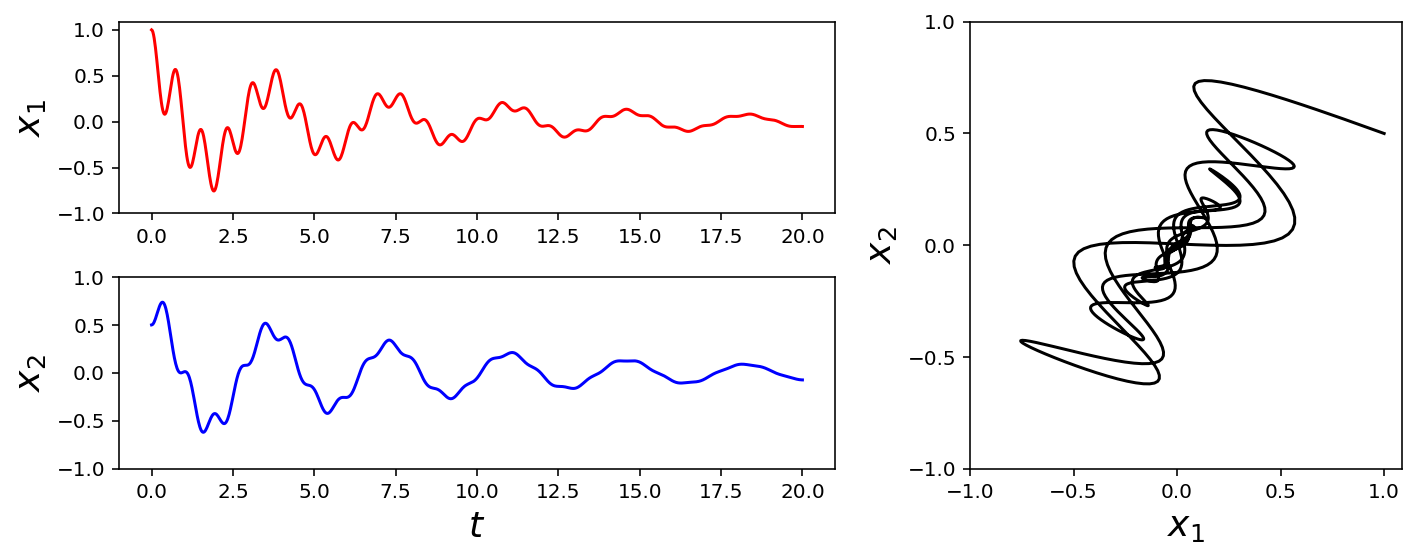

In [83]:
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

ax1.plot(t, y[:, 0], 'r')
ax1.set_ylabel('$x_1$', fontsize=18)
ax1.set_yticks([-1, -.5, 0, .5, 1])

ax2.plot(t, y[:, 2], 'b')
ax2.set_xlabel('$t$', fontsize=18)
ax2.set_ylabel('$x_2$', fontsize=18)
ax2.set_yticks([-1, -.5, 0, .5, 1])

ax3.plot(y[:, 0], y[:, 2], 'k')
ax3.set_xlabel('$x_1$', fontsize=18)
ax3.set_ylabel('$x_2$', fontsize=18)
ax3.set_xticks([-1, -.5, 0, .5, 1])
ax3.set_yticks([-1, -.5, 0, .5, 1])

fig.tight_layout()
fig.savefig('ch9-coupled-damped-springs.pdf')

* Same calculation as above, but with __specifying the Jacobian matrix__.
* Solver can use the Jacobian to solve system equations more efficiently.

In [84]:
def jac(t, y, args):
    m1, k1, g1, m2, k2, g2 = args
    
    return [[0, 1, 0, 0], 
            [- k1/m1 - k2/m1, - g1/m1 * y[1], k2/m1, 0],
            [0, 0, 1, 0],
            [k2/m2, 0, - k2/m2, - g2/m2]]

In [85]:
r = integrate.ode(f, jac)
r.set_jac_params(args)

* 1st pendulum is attached to a fixed support
* 2nd pendulum is attached to the 1st pendulum.
* m1,m2 = pendulum masses; l1,l2 = pendulum lengths

In [86]:
t,t,m1,l1,m2,l2 = sympy.symbols("t,g,m_1,l_1,m_2,l_2")
theta1, theta2 = sympy.symbols("theta_1, theta_2", cls=sympy.Function)

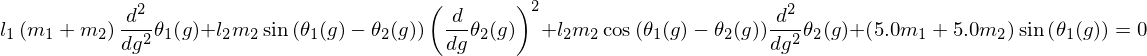

In [87]:
ode1 = sympy.Eq(
    (m1+m2)*l1 * theta1(t).diff(t,t) +
    m2*l2 * theta2(t).diff(t,t)  * sympy.cos(theta1(t)-theta2(t)) +
    m2*l2 * theta2(t).diff(t)**2 * sympy.sin(theta1(t)-theta2(t)) +
    g*(m1+m2) * sympy.sin(theta1(t)))
ode1

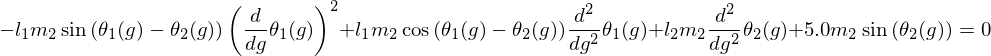

In [88]:
ode2 = sympy.Eq(
    m2*l2*theta2(t).diff(t,t)  +
    m2*l1*theta1(t).diff(t,t)  * sympy.cos(theta1(t) - theta2(t)) -
    m2*l1*theta1(t).diff(t)**2 * sympy.sin(theta1(t) - theta2(t)) +
    m2*g                       * sympy.sin(theta2(t)))
ode2

* ode1, ode2 are SymPy expressions for 2nd-order ODE equations
* __dsolve__ can't solve these - need a numerical method.
* Rewrite them as 4 1st-order ODEs in std form.
* Tedious if done by hand; let's automate with SymPy.

In [89]:
y1 = sympy.Function("y_1")
y2 = sympy.Function("y_2")
y3 = sympy.Function("y_3")
y4 = sympy.Function("y_4")

In [91]:
# create dict for variable change
varchange = {
    theta1(t).diff(t,t): y2(t).diff(t),
    theta1(t): y1(t),
    theta2(t).diff(t,t): y4(t).diff(t),
    theta2(t): y3(t)
}

In [92]:
# create add'l ODEs for y'1(t), y'3(t)
ode3 = y1(t).diff(t) - y2(t)
ode4 = y3(t).diff(t) - y4(t)

In [93]:
# solve to obtain ODEs in std form

y = sympy.Matrix([y1(t), y2(t), y3(t), y4(t)])

vcsol = sympy.solve(
    (ode1.subs(varchange), 
     ode2.subs(varchange), 
     ode3, 
     ode4),
    y.diff(t),
    dict=True)

f = y.diff(t).subs(vcsol[0])

In [94]:
# f is constructed so it can be converted to NumPy-aware function for odeint() or ode().

params = {m1: 5.0, l1: 2.0, m2: 1.0, l2: 1.0, g: 10.0}

_f_np = sympy.lambdify((t, y), f.subs(params), 'numpy')
f_np = lambda _t, _y, *args: _f_np(_t, _y)

jac = sympy.Matrix([[fj.diff(yi) for yi in y] for fj in f])
_jac_np = sympy.lambdify((t, y), jac.subs(params), 'numpy')
jac_np = lambda _t, _y, *args: _jac_np(_t, _y)

In [95]:
# 1st pendulum = 2X length, 5X weight as 2nd pendulum.

y0 = [2.0, 0, 0, 0]
tt = np.linspace(0, 20, 1000)
r = integrate.ode(f_np, jac_np).set_initial_value(y0, tt[0])
dt = tt[1] - tt[0]

yy = np.zeros((len(tt), len(y0)))
idx = 0
while r.successful() and r.t < tt[-1]:
    yy[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

In [96]:
# ODE solution now stored in yy with shape (1000,4)
# visualization: more intuitive to plot pendulum position in xy plane than angular deflection.
# tranforms between angular variables & x-y coordinates shown below.

theta1_np, theta2_np = yy[:, 0], yy[:, 2]

x1 =  params[l1] * np.sin(theta1_np)
y1 = -params[l1] * np.cos(theta1_np)

x2 = x1 + params[l2] * np.sin(theta2_np)
y2 = y1 - params[l2] * np.cos(theta2_np)

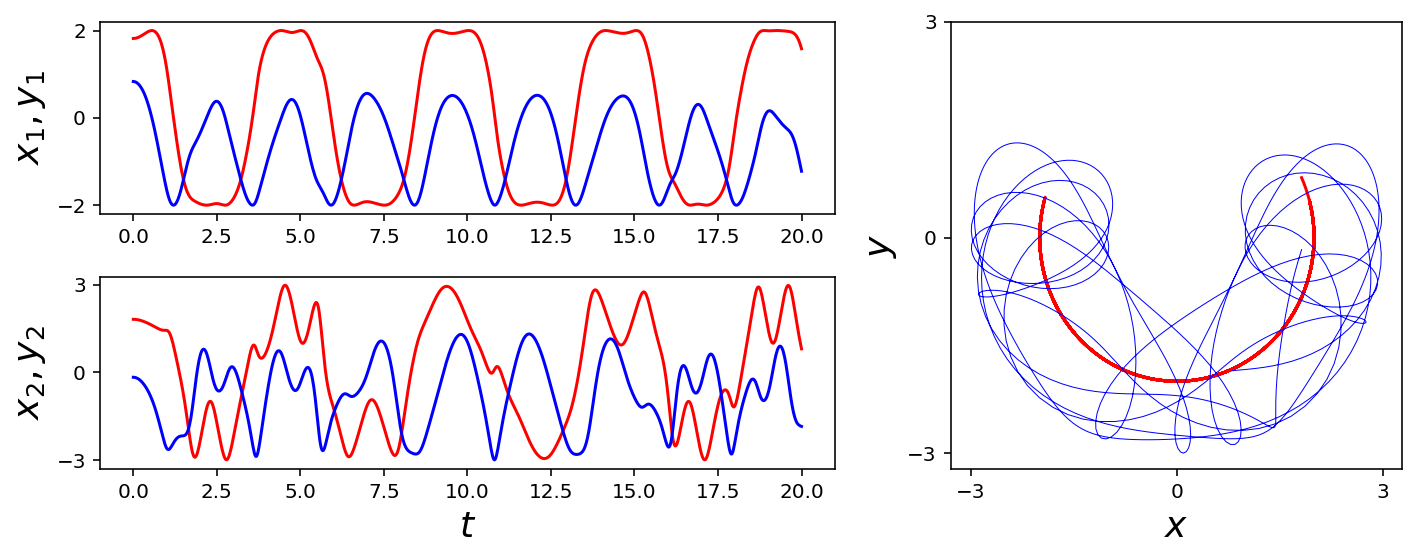

In [98]:
# plot double pendulum dynamics as function of time, in x-y plane.
# pendulum1 expected to move on a circle due to fixed anchor point
# pendulum2 has much more complicated trajectory.

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

ax1.plot(tt, x1, 'r')
ax1.plot(tt, y1, 'b')
ax1.set_ylabel('$x_1, y_1$', fontsize=18)

ax2.plot(tt, x2, 'r')
ax2.plot(tt, y2, 'b')
ax2.set_xlabel('$t$', fontsize=18)
ax2.set_ylabel('$x_2, y_2$', fontsize=18)
ax2.set_yticks([-3,0,3])

ax3.plot(x1, y1, 'r')
ax3.plot(x2, y2, 'b', lw=0.5)
ax3.set_xlabel('$x$', fontsize=18)
ax3.set_ylabel('$y$', fontsize=18)
ax3.set_xticks([-3,0,3])
ax3.set_yticks([-3,0,3])
fig.tight_layout()